



# Tensorflow Variational Quantum Neural Networks in Finance


### Abstract

Amongst the hottest topics at the moment are Quantum Computing and AI/ML. Recently a number of advances have made it easier to work with these technologies in a more practical manner. IBM’s Qiskit library for python has made it straightforward to experiment with this technology whether running live experiments on IBM Quantum or via a local QASM simulator. Similarly, Tensorflow Extended on the ML side takes all the TF magic and adds powerful MLOps tools to simplify deployment and management of ML pipelines. 

In this article, first of a series, we explore an approach that integrates these two different technologies. To demonstrate this, we will use daily price data for a single RIC and engineer some simple features to generate a simple signal using a Variational Quantum Neural layer integrated with a classical Neural Network Tensorflow structure. Because of the nature of the interaction such structures are called Variational Quantum Neural Networks.

The Eikon Data API is an excellent way to get access to the breadth of features available from the- Refinitiv Eikon/Workspace ecosystem. It allows disciplines such as data scientists, analysts, and quants to experiment, prototype or productionise a multitude of use cases that can be derived from such a rich data ecosystem. It also allows quick prototyping and then deployment into production at scale using the Refinitiv Data Platform with code portability.



### The Variational hybrid Classical-Quantum Neural Network

To understand the way the Variational Quantum Neural Network (VQNN) works let’s first have a look at how classical and quantum computing can interact with each other at present. The following graph depicts such an interaction:

![classical-quantum cylcle](img/lifecycle.png)

In broad terms, at the first stage, the classical algorithm creates an output. The classical output is converted into a quantum input and sets the initial state of the quantum registers, thereafter the quantum circuit executes producing a quantum output. In the case of an optimisation problem such as a neural network, a classical optimiser can observe that output and respectively update any parameters involved in the optimisation. The process repeats until some classical stopping criteria are fulfilled.

#### Basic structures of quantum computing
To understand the quantum paradigm, we need to briefly discuss some of the basic characteristics of quantum computers. At the heart of a quantum computer lies the qubit.  Qubits share some characteristics with classical bits. Like a bit, a qubit, when measured, will collapse into one of two classical states, 0 or 1, exactly as we are used to in classical computing. However, a qubit state |Q> is a linear combination of its basis states, |0> or |1>, the analogous of the classical bit states 0 and 1. However, |0> and |1> is now a vector rather than a simple integer. The qubit can be written as:
Define symbols to give more clarity to readers new to quantum

![Qubit basic](img/qubit_basic.png)

This translates to the fact that a qubit can stay in a superposition between the two states. There are in fact two main degrees of freedom available on a qubit, so the equation can be expanded a bit further:

![Qubit expanded](img/qubit_expanded.png)

Where θ (theta) and φ (phi) can be seen in the following schematic. The probability of a qubit collapsing to either 0 or 1 is directly dependent to θ since it determines the distance of |Ψ> from |0> or |1>. While φ does not affect this probability, it is a very important parameter in the quantum computing space. We refer to φ as the phase of the qubit. There is also a third degree of freedom which is the global phase γ (gamma) but it does not show up in this equation. The full-blown qubit state equation can be written: 

![Qubit full](img/qubit_full.png)

Ignoring global phase γ on the outer term and defining phase as φ=γ-δ we end up with the former and most used form of the qubit state equation.

![Qubit](img/qubit.png)


### The Quantum Layer structure and forward phase 

From a bird’s eye view, the behaviour of a quantum layer is not very different from that of a classical one. In a Tensorflow Sequential neural network structure, during the forward phase, the previous layer drives the quantum layer, and the weighted outputs are responsible to set the initial states of the quantum register. There are a few mathematical transformations that perform the integration and similarly the output of the layer, reflects the probability of the register to collapse to one of the possible states. It can be used to drive forward the next layer in the neural network. The integration with the Tensorflow optimisers has been implemented in the QuantumDense layer module. The QuantumDense layer module inherits from the tensorflow.keras.layers.Layer overriding all necessary functionality to implement a quantum qiskit circuit that is able to calibrate its qubits depending on the input it receives. Because it inherits from a Tensorflow layer structure it can be used as any of the available layers in the framework. The next schematic how a 4-Qubit quantum layer may be connected to a previous classical three neurons layer. The output of the QuantumDense layer is a continuous vector with as many constituents as the qubits used. 

![Quantum layer](img/VQNN.png)

The following diagram shows the class relationships implementing the current Quantum dense functionality. We can see how the layer is derived from the appropriate Tensorflow class and is used within a tensorflow.keras.Model. All the Quantum functionality is implemented within the QiskitCircuitModule class. Instantiating a VQNNModel is enough to get access to all the Tensorflow training and predictive functionality. The actual structure of the VQNN can be altered within the same class.

![Class diagram](img/classes.png)

### The backpropagation phase
During the backpropagation phase, in classical AI we need to calculate the backpropagated error gradient ni order to update the weights of the neural network. However, in the case of a quantum layer we introduce a break in the continuity of the calculations. To work-around this we can use a technique called the parameter shift rule. In short, if we assume the quantum circuit as a black box and we introduce a small shift s in theta values, its gradients can be calculated as follows:

                                                  ∇θQ(θ)= Q(θ+s)- Q(θ-s)

Such gradient calculations are used in the optimisation step of many algorithms such as Quantum Approximate Optimisation Algorithms (QAOA), autoencoders and the Variational Quantum Eigensolver (VQE). To simplify this first attempt to integrate qiskit with Tensorflow we implement a simpler gradient workaround during optimisations to allow the GradientTape flow to execute.


### Importing necessary libraries

As mentioned, we will use the Eikon Data API to load five years’ worth of daily price data for a RIC, let’s use IBM.N, and we will try to generate a simple trading signal using the VQNN. Let’s first import all necessary libraries and initialise a viewing option in pandas as well as set our appkey:

In [3]:
import numpy as np
import os
import eikon as ek
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import eikon as ek
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from QuantumDense import VQNNModel

import matplotlib.dates as plt_dates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from QuantumDense import VQNNModel

### Loading timeseries data using the Eikon Data API

Loading timeseries data using the Eikon Data API is as simple as a call to the function get_timeseries(), passing the relevant parameters for RIC and data time windows:

In [7]:
RIC_LIST = ['IBM.N']
if not os.path.isfile('./ibm.csv'):
    ek.set_app_key('')
    df = ek.get_timeseries(RIC_LIST,
                           start_date='2016-01-01',
                           end_date='2021-10-01',
                           interval='daily',)
    df.to_csv('./ibm.csv')
else:
    df = pd.read_csv('./ibm.csv')

### Generating some basic features

In the next step, we generate some basic features, RETURNS, PRX_MA_ND the moving average of price last 5 days and VOLATILITY. We will use those as the inputs to our VQNN. Using returns as an input implies that we expect next day’s returns to be correlated with the previous day returns. While there are better structures to analyse this type of autocorrelations, we are keeping the model simple for the sake of the example. 

In [8]:
df['HL_DELTA'] = df['HIGH'] - df['LOW']
df['RETURNS'] = df['CLOSE'].pct_change()
df['PRX_MA_ND'] = df['CLOSE'].rolling(window=5).mean()
df['VOLATILITY'] = df['CLOSE'].rolling(window=5).std()
df['TP1_RETURNS'] = df['RETURNS'].shift(-1)

df.dropna(inplace=True)
df = df.set_index('Date')

df

,HIGH,CLOSE,LOW,OPEN,COUNT,VOLUME,HL_DELTA,RETURNS,PRX_MA_ND,VOLATILITY,TP1_RETURNS
Date,,,,,,,,,,,
2016-01-08,133.81,131.63,131.35,133.11,6584,1183531,2.46,-0.009258,134.292,1.941911,0.012155
2016-01-11,133.80,133.23,131.76,131.81,7245,1453294,2.04,0.012155,133.748,1.730844,-0.002477
2016-01-12,133.75,132.90,131.14,133.60,7540,1287206,2.61,-0.002477,133.158,1.279011,-0.013017
2016-01-13,134.27,131.17,131.10,133.50,7875,1358898,3.17,-0.013017,132.358,0.901038,0.013265
2016-01-14,133.79,132.91,131.24,131.93,9502,1635465,2.55,0.013265,132.368,0.908251,-0.021669
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,139.07,138.67,137.60,138.14,5353,796605,1.47,0.004418,139.124,0.768459,-0.006707
2021-09-09,138.96,137.74,137.56,138.10,4436,1264913,1.40,-0.006707,138.812,0.969521,-0.005227
2021-09-10,139.35,137.02,137.00,138.82,6551,1335238,2.35,-0.005227,138.214,0.967977,0.008247


### Feature transformations and preparation for training

We will be setting the next day up or down tick of returns TP1_RET_UDT as the target variable for our model, effectively turning this into a classification problem. We will also be setting aside 2021 data for forward trading tests. Making sure that the data flowing through our model are of similar scale and in the preferable range of values for a neural network, we apply standard scaling to all the data. An important detail here is that the standard scaler is trained on the back testing data and to avoid look ahead biasing we need to use the fitted scaler on the forward trading data. We also do the usual train test split for the purposes of training and evaluating our models.

Before we use the training and validation sets created, we need makethem  Tensorflow friendly. Tensorflow utilises tensors as its main data structure. Tensors are very versatile structures able to store higher dimensional data. The following schematic, borrowed from the Tensorflow documentation, shows a 3 dimensional tensor.

In [10]:
df_x = df[['RETURNS', 'VOLUME', 'PRX_MA_ND', 'VOLATILITY']]
df_y = df['TP1_RETURNS']

df_x

,RETURNS,VOLUME,PRX_MA_ND,VOLATILITY
Date,,,,
2016-01-08,-0.009258,1183531,134.292,1.941911
2016-01-11,0.012155,1453294,133.748,1.730844
2016-01-12,-0.002477,1287206,133.158,1.279011
2016-01-13,-0.013017,1358898,132.358,0.901038
2016-01-14,0.013265,1635465,132.368,0.908251
...,...,...,...,...
2021-09-08,0.004418,796605,139.124,0.768459
2021-09-09,-0.006707,1264913,138.812,0.969521
2021-09-10,-0.005227,1335238,138.214,0.967977


In [11]:
df_y

Date
2016-01-08    0.012155
2016-01-11   -0.002477
2016-01-12   -0.013017
2016-01-13    0.013265
2016-01-14   -0.021669
                ...   
2021-09-08   -0.006707
2021-09-09   -0.005227
2021-09-10    0.008247
2021-09-13   -0.013970
2021-09-14    0.007194
Name: TP1_RETURNS, Length: 1431, dtype: float64

In [12]:
df_x_scaler = MinMaxScaler().fit(df_x)

forward_test_date = '2021-03-01'

fdf_x = df_x.loc[forward_test_date:]
fdf_y = df_y.loc[forward_test_date:]
df_x = df_x.loc['2021-01-01':'2021-03-01']
df_y = df_y.loc['2021-01-01':'2021-03-01']

fdf_prx = df.loc[forward_test_date:]['CLOSE']
fdf_y_len = len(fdf_y)

df_x_scaled = pd.DataFrame(df_x_scaler.transform(df_x))
fdf_x_scaled = pd.DataFrame(df_x_scaler.transform(fdf_x))

x_train, x_test, y_train, y_test = train_test_split(df_x_scaled,
                                                    df_y,
                                                    test_size=0.25,
                                                    random_state=42)

x_train

,0,1,2,3
17,0.451281,0.129911,0.253168,0.173354
8,0.598959,0.142143,0.351723,0.073107
16,0.531406,0.196989,0.281689,0.494096
12,0.582056,0.113762,0.366267,0.110197
19,0.581792,0.107415,0.259232,0.130308
9,0.513462,0.098419,0.351378,0.072989
32,0.472408,0.071582,0.249051,0.057431
0,0.468271,0.123735,0.303826,0.067760
25,0.481503,0.037836,0.266504,0.143854
5,0.533693,0.120921,0.350047,0.106694


Before we use the training and validation sets created, we need to make them  Tensorflow friendly. Tensorflow utilises tensors as its main data structure. Tensors are very versatile structures able to store higher dimensional data. The following schematic, borrowed from the Tensorflow documentation, shows a 3 dimensional tensor.

![tensor](img/tensor.png)

In [13]:
x_train = np.expand_dims(x_train.values, 1).astype(np.float32)
y_train = np.expand_dims(y_train.values, 1).astype(np.float32)
x_validation = np.expand_dims(x_test.values, 1).astype(np.float32)
y_validation = np.expand_dims(y_test.values, 1).astype(np.float32)

### Instantiating the VQNN model and tensorboard callbacks

We can now generate the Tensorflow structure of the VQNN, a three-layered structure is instantiated through the VQNNModel class, a dense driver layer, the   quantum layer of 5 qubits will act as the interim layer before a classical single neuron regression layer. The model is compiled, and the optimiser options are set. The model needs to execute eagerly in Tensorflow which is the default behaviour in Tensorflow 2.x in order to pass the calculations to the QuantumDense layer.

Tensorboard is a very useful tool in the Tensorflow ecosystem allowing us to monitor and understand the behaviour of the model during training and validation. Let’s write some code to create some logs to observe:

In [6]:
qnn_model = VQNNModel()
log_dir = "logs\\model\\eikon\\"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
qnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                     beta_1=0.9,
                                                     beta_2=0.999,
                                                     epsilon=1e-07),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=["mean_squared_error"])


### Training the VQNN model

Tensorflow is running successfully optimising the structure. The integration works fine, and all the layer parameters are getting optimised. This means that the qubit parameters, theta, and phi, as well as all the classical parameters are now being optimised. Once the process is done, it is time to use the model as a predictor. We write a list comprehension to turn probabilistic forecasts to a signal:

In [7]:
qnn_model.run_eagerly = True
qnn_model.fit(x_train, y_train, epochs=1, batch_size=1, callbacks=[tensorboard_callback])

Job Status: job has successfully run
Job Status: job has successfully run.] - ETA: 27s - loss: 0.0850 - mean_squared_error: 0.0850
Job Status: job has successfully run.] - ETA: 2:16 - loss: 0.0763 - mean_squared_error: 0.0763
Job Status: job has successfully run.] - ETA: 2:11 - loss: 0.0722 - mean_squared_error: 0.0722
Job Status: job has successfully run.] - ETA: 2:06 - loss: 0.0712 - mean_squared_error: 0.0712
Job Status: job has successfully run.] - ETA: 2:01 - loss: 0.0657 - mean_squared_error: 0.0657
Job Status: job has successfully run.] - ETA: 1:56 - loss: 0.0659 - mean_squared_error: 0.0659
Job Status: job has successfully run.] - ETA: 1:50 - loss: 0.0719 - mean_squared_error: 0.0719
Job Status: job has successfully run.] - ETA: 1:45 - loss: 0.0682 - mean_squared_error: 0.0682
Job Status: job has successfully run.] - ETA: 1:40 - loss: 0.0661 - mean_squared_error: 0.0661
Job Status: job has successfully run.] - ETA: 1:35 - loss: 0.0638 - mean_squared_error: 0.0638
Job Status: jo

### Monitoring and evaluating the VQNN

Let’s have a look at some of the output of Tensorboard, remember that we have set a log file in the code to monitor every epoch. Aside from being able to monitor any type of valuation metric throughout the entire training lifecycle there are many interesting visualisations within Tensorboard to help understand what is happening within the structure during training. Here’s for example a loss chart:


![Epoch loss](img/loss.png)

The next two diagrams are also very interesting showing how the QuantumDense layer distributions evolve.

![tensorboard logs](img/p.png)

Aligned with quantum theory, in this circuit, nothing is changing on the phase constituent side. This is proof that the layer is behaving as expected. Because there are no complex instructions appended to this quantum layer, qubit phases are not affecting the probabilities of the outputs, therefore the optimiser will leave them intact.  

![tensorboard logs](img/phase.png)

Let’s also have a look at the outputs of the QuantumDense layer during the first three epochs of training, the output is based on 10 shot executions of the quantum circuits. 

![qiskit results](img/bar-chart.png)

### Making predictions and generating the signal

We can now write some code to support a forward test of the trading signal and visualise the results. A simple function is used to calculate profit and loss based on the generated signal and 2021 data:

In [24]:
num_of_features = fdf_x_scaled.shape[1]
qnn_predictions = []
for entry in fdf_x_scaled.iterrows():
    fdf_x_predict_tensor = tf.reshape(tf.convert_to_tensor(entry[1]), [1, num_of_features])
    qnn_forecast = qnn_model.predict(fdf_x_predict_tensor)
    qnn_predictions.append(qnn_forecast[-1, -1, -1])

signal = [0 if x <= 0.04 else 1 for x in qnn_predictions]

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

### Calculating signal P&L

We can now write some code to support a forward test of the trading signal and visualise the results. A simple function is used to calculate profit and loss based on the generated signal and 2021 data:

In [ ]:
def calculate_pnl(signal, returns):
    pnl = [1]
    c_pnl=1
    for i, s in enumerate(signal):
        c_pnl *= (1 + s * returns[i])
        pnl.append(c_pnl)
    return pnl

signal_prx = []
for i in range(0, fdf_y_len):
    s = np.NaN
    if signal[i]:
        s = fdf_prx[i]
    signal_prx.append(s)

pnl = calculate_pnl(signal, fdf_y.to_list())

### Ploting the price, signal and P&L

We then use matplotlib to visualise the P&L curve on the generated signal. We can see that the simple VQNN structure generated a decent signal making roughly a 12% profit over a period of 175 days’ worth of forward trading in 2021. This is of course a very loose assumption as no other factors are considered such as TCA, maintenance, and post trading analytics. However, the fact that we can write a prototype ingesting EIKON data within the Tensorflow ecosystem for AI using the new QuantumDense layer is evidence of a good functional integration of quantum and classical computing.

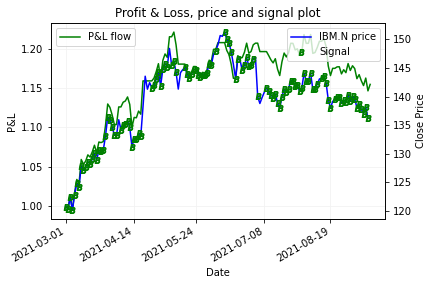

In [26]:
fig, ax = plt.subplots()

plt.grid(axis='both', color='0.95')
plt.xticks(rotation=45)
plt.xticks(range(0, int(fdf_y_len), 10))
ax.plot(range(len(pnl)), pnl, label='P&L flow', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('P&L')
ax.set_title("Profit & Loss, price and signal plot")
ax.legend(loc='upper left')
ax_prx = ax.twinx()
ax_prx.plot(fdf_prx, label='IBM.N price', color='blue')
ax_prx.set_ylabel('Close Price')
ax_prx.plot(signal_prx, label='Signal', color='green', marker='$B$', linestyle='None')
ax_prx.legend()
ax.xaxis.set_major_locator(plt_dates.MonthLocator(interval=1))

plt.gcf().autofmt_xdate()
plt.show()


### What if I wanted to inject a more complex circuit within the Quantum neural layer?

The QuantumDense layer supports any gated circuit connected to it so you can add any circuit after the quantum register - taking advantage of more complex concepts in the world of quantum computing such as entanglement, phase kickbacks, phase state amplifications and more. These concepts are very important in Quantum computing and extensively used in algorithmic quantum circuits. Entanglement is the process of binding two qubits together in a fully deterministic relationship. For example, there exist quantum gates that will always set a qubit to |1> depending on the state of another qubit. Phase kickback and phase amplification are also extensively used when we want to select most dominant states out of all the possible ones and are used in Monte Carlo quantum simulations. All these concepts can be introduced as part of a QuantumDense layer within a VQNN structure. To do so, use the following syntax to generate the appropriate circuit through Qiskit, convert it to an instruction module and pass it as a parameter to the QuantumDense layer. 

In [ ]:
sub_qr = QuantumRegister(10)
sub_circuit = QuantumCircuit(sub_qr, name='sub_circ')
sub_circuit.crz(1, sub_qr[0], sub_qr[5])
sub_circuit.barrier()

# Convert to a gate instruction and connect it with the QuantumDense registers
sub_instructions = sub_circuit.to_instruction()


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    QuantumDense(qubits=10, instructions=sub_instructions)
])


In this example, the QuantumDense layer consists of the base quantum layer followed by a quantum circuit entangling qubits 1 and 5. 

![entanglement](img/ent.png)

### Results and thoughts

This article showcases how a Variational Quantum Neural Network can be used within the EIKON ecosystem to write prototypes leveraging the rich data ecosystem provided from Refinitv. We have used a simple trading signal as our use case. The VQNN is based on the QuantumDense module, an experimental quantum layer implemented in python and Qiskit tightly integrated with Tensorflow. 

In the future, we will be trying the infrastructure in other data scenarios. The QuantumDense layer can participate both in regression and classification AI structures. We will explore scenarios injecting a more complex quantum layer into the architecture, using the methodology described in the article, thereby taking advantage of more complex concepts of Quantum computing. 

Finally, because QuantumDense is based on Qiskit it is possible to execute the VQNN in a real hybrid infrastructure scenario where the quantum layers can be executed on a true quantum computer on IBM Quantum.  We will be exploring an integration and an actual execution of the structure as well as the parameter shift rule on a following article. Due to the nature of the execution lifecycle as well as the added complexity of the optimisation algorithm, Wwe expect that training and execution times might be somewhat lengthy, however the experiment on its own can be very insightful.
